# RAGU radar pick length calculator
Notebook designed to calculate the length of radar data interpreted and uninterpreted.

RAGU pick files may contain arrays for a particular track which have picks along subsections of that track.

Therefore, calculating the total length of all line segments will over-estimate the length of picked data.

Here, we split up tracks based on the trace increment and then calculate the length of measurements in line-km.

BST 20221206


### psuedocode ###
1. read in dataset containing RAGU radar picks
    a. remove nulls where no picks were made
2. break up each track into subsections based on the trace increment
    a. if the along-track trace increment is greater than 1, split track measurements into n chunks
3. create geodataframe and make linestring from points
4. calculate measurement distance

In [2]:
### impots ###
import sys, os, itertools
import numpy as np
import pandas as pd
import pyproj
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches

%matplotlib inline
plt.rcParams["font.family"] = "Calibri"
plt.rcParams['font.size'] = 8
plt.rcParams['legend.fontsize'] = 8
pd.set_option('display.max_rows', 500)

In [3]:
### params ###
dpath = "C:/Users/btober/OneDrive/Documents/tmp/"
df = pd.read_csv(dpath + 'ruth_picks.csv')  
df.head()

,X,Y,track,trace,lon,lat,elev,z,h
0,614413.558583,6.985239e+06,20220501_212721,248,-150.74250,62.978830,1612.5896,1173.413422,439.176177
1,614415.350567,6.985246e+06,20220501_212721,249,-150.74246,62.978890,1612.2338,1168.834740,443.399025
2,614416.721927,6.985250e+06,20220501_212721,250,-150.74243,62.978928,1611.9841,1164.362258,447.621873
3,614417.079966,6.985254e+06,20220501_212721,251,-150.74242,62.978966,1611.7542,1159.909430,451.844721
4,614417.929016,6.985259e+06,20220501_212721,252,-150.74240,62.979008,1611.6509,1155.583310,456.067569


In [4]:
# filter out any nulls
df = df[df.h.notnull()]
df = df[df.z.notnull()]

Need to split up points for a given track based on the trace interval.

If the difference betweeen consecutive traces in the dataframe is greater than 1, we want to create a new linesegment

In [5]:
# # create new df
df2 = pd.DataFrame()

# get unique track names
tracks = df.track.unique()

# loop through tracks and split points by trace chunks - where diff of trace is greater than 1
for t in tracks:
    # print(t)
    subdf = df[df.track == t]
    # ensure we're sorted by increasing trace value
    subdf = subdf.sort_values(by=['trace'],ignore_index=True)
    # get along track difference in trace index
    diff = np.diff(subdf.trace)
    # find where difference in trace value is greater than 1
    idx = np.where(diff > 1)
    # determine how many chunks in track based on trace diff. nchunks will be idx[0].shape[0]+1 (one split means two subsections, etc.)
    nchunks = idx[0].shape[0] + 1

    # now iterate and split subsections if there's more than 1 chunk
    if nchunks > 1:
        # print(t)
        # plt.figure()
        # plt.plot(diff,'.')
        for i in range(nchunks):
            # print(traces.iloc[idx[0][i]-1], traces.iloc[idx[0][i]], traces.iloc[idx[0][i]+1])
            if i == 0:
                start = 0
                stop = idx[0][i]

            elif i >= 1:
                start = idx[0][i - 1] + 1
                if i == nchunks-1:
                    stop = subdf.index[-1]
                else:
                    stop = idx[0][i]

            # add subset to gpd as with new track id
            # print(start,stop)
            # print(subdf.trace.iloc[start],subdf.trace.iloc[stop])
            sub = subdf.iloc[start:stop]
            sub.track = t + '_' + str(i)
            df2 = df2.append(sub)
            
    else:
        df2 = df2.append(subdf)    

c:\Users\btober\anaconda3\envs\py3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [6]:
# convert points in each track to linestring grouped by track
# zip the coordinates into a point object and convert to a shapely geodataframe
geometry = [Point(xy) for xy in zip(df.X, df.Y)]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

geometry = [Point(xy) for xy in zip(df2.X, df2.Y)]
gdf2 = gpd.GeoDataFrame(df2, geometry=geometry)

# aggregate points by track using groupby and set as a linestring
gdf = gdf.groupby(["track"])["geometry"].apply(lambda x: LineString(x.tolist()))
gdf = gpd.GeoDataFrame(gdf, geometry="geometry")
gdf2 = gdf2.groupby(["track"])["geometry"].apply(lambda x: LineString(x.tolist()))
gdf2 = gpd.GeoDataFrame(gdf2, geometry="geometry")

In [7]:
print(f'acquired radar data length {round(np.sum(gdf.length)*1e-3,3)} line-km') 
print(f'picked radar data length {round(np.sum(gdf2.length)*1e-3,3)} line-km') 

acquired radar data length 54.785 line-km
picked radar data length 49.98 line-km


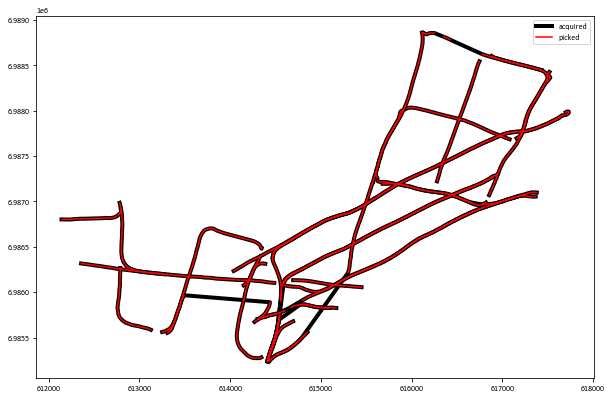

In [16]:
fig, ax = plt.subplots(1,figsize=(10,10))

for i in gdf.geometry:
    ln0, = ax.plot(*i.xy, 'k', lw=4)

for i in gdf2.geometry:
    ln1, = ax.plot(*i.xy, 'r')
ax.set_aspect('equal')
ax.legend(handles=[ln0,ln1], labels=['acquired','picked'])
